## Work:
The equation for the work done in the system can be found as:
$$W = - \int_{V_i}^{V_f}P(V)dV$$
Where the equation for pressure is:
$$P = \frac{nRT}{V}$$
Meaning work can be written as:
$$W = - nRT \int_{V_i}^{V_f} \frac{dV}{V}$$
$$W = nRT(ln(\frac{V_i}{V_f}))$$

In [1]:
# Creating functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

# Set R as a global variable
R = 8.314

def delta_work(v_i, v_f, t_i, t_f, n):
    delta_T = t_i - t_f
    delta_w = n * R * delta_T * np.log(v_i/v_f)
    return delta_w

def work(v_i, v_f, n, T):
    work = n * R * T * (np.log(v_i/v_f))
    return work

def delta_work(t_f, t_i, v_f, v_i, f):
    efficiency = (t_f - t_i)/(t_f + (f/2)*((t_f - t_i)/(np.log(v_f/v_i))))
    return efficiency

def pressure_function(v, T, n):
    pressure = (n * R * T)/v
    return pressure

def fit_pressure(vol_data, press_data, t_est, n_est):
    # Find estimates for T and n
    p0 = [t_est, n_est]
    bounds = ([0,0], [500, 2])
    
    popt, pcov = curve_fit(pressure_function, vol_data, press_data, p0=p0, bounds=bounds)
    temp_fit, n_fit = popt
    sigma_temp, sigma_n = np.sqrt(np.diag(pcov))
    
    return temp_fit, sigma_temp, n_fit, sigma_n

def graph_curve_fit(vol_data, press_data, t_est, n_est, filename):

    temp_fit, sigma_temp, n_fit, sigma_n = fit_pressure(vol_data, press_data, t_est, n_est)

    # Use values to plot pressure function against data
    p_fitted = pressure_function(vol_data, temp_fit, n_fit)

    plt.scatter(vol_data, press_data, label='Data', s=1, color='red')
    plt.plot(vol_data, p_fitted, label='Curve Fit', color='blue')
    plt.xlabel("Volume (m^3)")
    plt.ylabel("Pressure (Pa)")
    plt.title(f'T={temp_fit:.2f}K +/- {sigma_temp:.2e} K, n={n_fit:.2e} mols +/- {sigma_n:.2e} mols')
    plt.savefig(filename)
    plt.legend()
    plt.show()

    return temp_fit, sigma_temp, n_fit, sigma_n

    

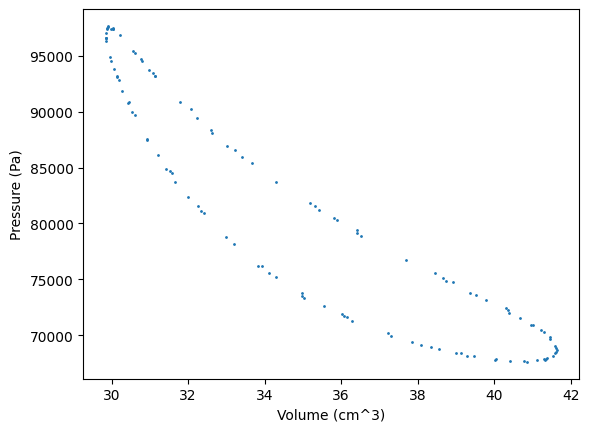

In [2]:
# Load data in dfs
df_1 = pd.read_csv("run1.csv", header=0, 
                   names=["time", "angle", "volume", "pressure","temp1", "temp2"])

time_df = df_1["time"]/1000 # s
radians = df_1["angle"]
volume = df_1["volume"] # cm^3
pressure = df_1["pressure"] * 1000 # Pa
heater_temp = df_1["temp1"] + 273.15 # K
heatsink_temp = df_1["temp2"] + 273.15 # K

plt.scatter(volume, pressure, s=1)
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (Pa)")
plt.show()

# Splitting graph into low and high pressure sections
In order to find the value for total work done in this process, we'll need to find the area of the graph between the high and low pressure sections of the graph. Or in other words, we can find the work of the high pressure section and subtract the work of the low pressure section to find only the work done between the two. In order to accomplish this, we must first split the data in half along where the data turns around in it's cycle in either direction.

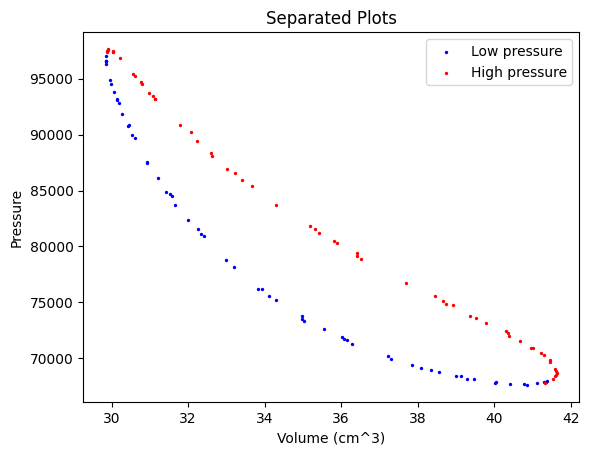

In [3]:
def lowerPresSection():
    lowSortingPres = np.zeros(len(pressure))

    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] >= pres:
                lowSortingPres[i] = pres
            elif pressure[i+1] <= pres:
                lowSortingPres[i] = 0
        else:
            lowSortingPres[i] = 0
            break

    low_pressure = []
    low_volume = []
    for i, lowPres in enumerate(lowSortingPres):
        if lowPres > 0:
            low_pressure.append(lowPres)
            low_volume.append(volume[i])

    return low_volume, low_pressure

def higherPresSection():
    highSortingPres = np.zeros(len(pressure))
    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] <= pres:
                highSortingPres[i] = pres
            elif pressure[i+1] >= pres:
                highSortingPres[i] = 0
        else:
            highSortingPres[i] = 0
            break
    high_pressure = []
    high_volume = []
    for i, highPres in enumerate(highSortingPres):
        if highPres > 0:
            high_pressure.append(highPres)
            high_volume.append(volume[i])

    return high_volume, high_pressure

low_volume, low_pressure = lowerPresSection()
high_volume, high_pressure = higherPresSection()

# Sorting plots to remove discontinuities caused by different cycles
sorted_low_pressure = sorted(zip(low_volume, low_pressure), key=lambda x: x[0])
sorted_lvolume, sorted_lpressure = zip(*sorted_low_pressure)
plt.scatter(sorted_lvolume, sorted_lpressure, s=2, color="blue")

sorted_high_pressure = sorted(zip(high_volume, high_pressure), key=lambda x: x[0])
sorted_hvolume, sorted_hpressure = zip(*sorted_high_pressure)
plt.scatter(sorted_hvolume, sorted_hpressure, s=2, color="red")

plt.title("Separated Plots")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure")
plt.legend(["Low pressure", "High pressure"])
plt.savefig('Separated Plots.png')
plt.show()


# Finding error margins with curve_fit
Now that we have the high and low pressure regions plotted separately, we can use the fit_pressure function defined earlier along with the values measured by the thermocouples to find values for T and n alongside error estimates. 

As the system was heating for multiple minutes before the data collection began, and as the system is not ideal, the temperature doesn't fluctuate in the way it might be expected to under the ideal gas law. Instead, when plotted against time, the temperature of the thermocouple closer to the heat source rises continuously while the thermocouple attached to the heat sink has more of a square-wave depiction. However, both of the graphs barely fluctuate in temperature at all, and only by steps related to the sensitivity of the detectors. As a result, we'll plot the temperatures here and then use their average values to estimate n.

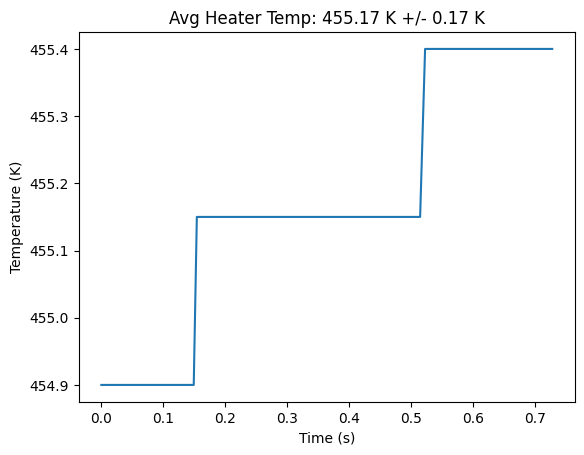

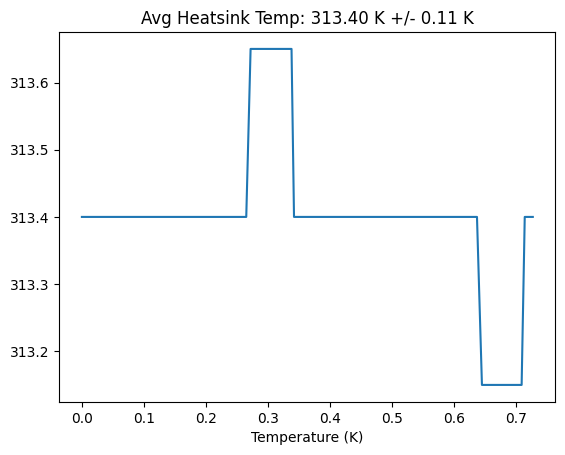

In [4]:
# Plotting temperature/time plots
avg_heater_temp = np.mean(heater_temp)
heater_temp_std = np.std(heater_temp)
plt.plot(time_df, heater_temp)
plt.xlabel(f'Time (s)')
plt.ylabel(f'Temperature (K)')
plt.title(f'Avg Heater Temp: {avg_heater_temp:.2f} K +/- {heater_temp_std:.2f} K')
plt.show()

avg_heatsink_temp = np.mean(heatsink_temp)
heatsink_temp_std = np.std(heatsink_temp)
plt.plot(time_df, heatsink_temp)
plt.xlabel(f'Time (s)')
plt.xlabel(f'Temperature (K)')
plt.title(f'Avg Heatsink Temp: {avg_heatsink_temp:.2f} K +/- {heatsink_temp_std:.2f} K')
plt.show()

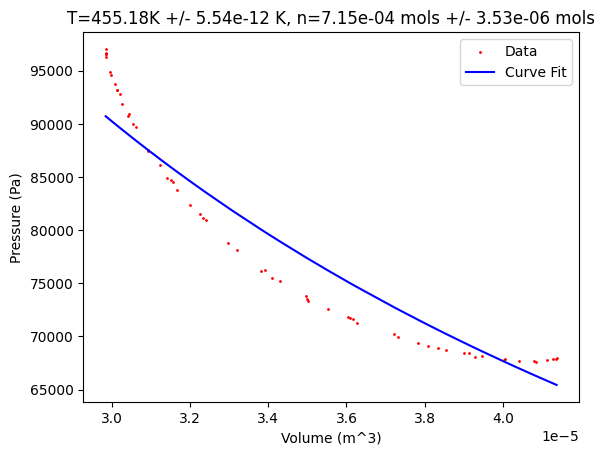

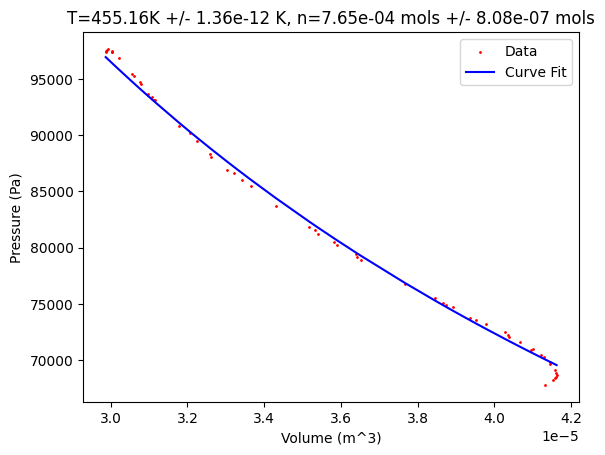


Work on low pressure section of graph: 0.88 J
Work on high pressure section of graph: 0.96 J
Total work: 7.71e-02 J


In [5]:
# Performing curve_fit

# convert volume from cm^3 to m^3 for low and high pressure graphs
sorted_lvolume_converted = np.array(sorted_lvolume)
sorted_lvolume_converted = sorted_lvolume_converted / 1e6

sorted_hvolume_converted = np.array(sorted_hvolume)
sorted_hvolume_converted = sorted_hvolume_converted / 1e6

n_est = 0.0007
temp_fit, sigma_temp, low_n_fit, sigma_n = graph_curve_fit(sorted_lvolume_converted, sorted_lpressure, avg_heater_temp, n_est, "low pressure fit.png")

v_i_low_press = np.min(sorted_lvolume_converted)
v_f_low_press = np.max(sorted_lvolume_converted)

temp_fit, sigma_temp, high_n_fit, sigma_n = graph_curve_fit(sorted_hvolume_converted, sorted_hpressure, avg_heater_temp, n_est, "high pressure fit.png")

v_i_high_press = np.min(sorted_hvolume_converted)
v_f_high_press = np.max(sorted_hvolume_converted)

low_work = work(v_i_low_press, v_f_low_press, low_n_fit, avg_heater_temp)
high_work = work(v_i_high_press, v_f_high_press, high_n_fit, avg_heater_temp)
# For some reason, the values are coming out negative
low_work, high_work = -low_work, -high_work
engine_work = high_work - low_work
print(f'\nWork on low pressure section of graph: {low_work:.2f} J')
print(f'Work on high pressure section of graph: {high_work:.2f} J')
print(f'Total work: {engine_work:.2e} J')

# Comparing to an interpolated model

Work done by Stirling Engine: 9.43e-02 J


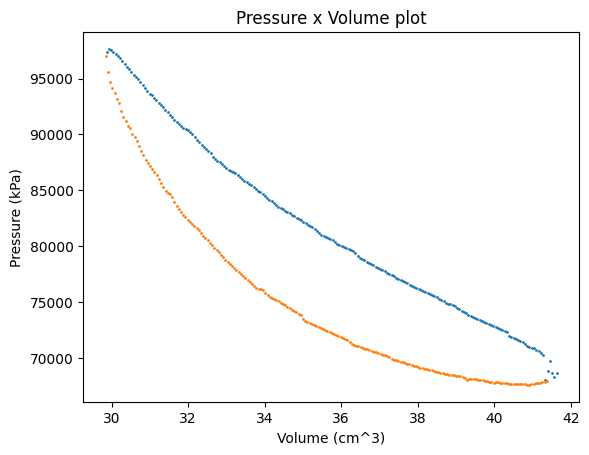

The difference between the two calculated works is only: 1.72e-02 J


In [6]:
v_i, v_f = sorted_lvolume[0], sorted_lvolume[-1]
p_i, p_f = sorted_lpressure[0], sorted_lpressure[-1]

interpVolHigh = np.linspace(sorted_hvolume[0], sorted_hvolume[-1], 200)

interpPresHigh = np.interp(interpVolHigh, sorted_hvolume, sorted_hpressure)

interpVolLow = np.linspace(sorted_lvolume[0], sorted_lvolume[-1], 200)

interpPresLow = np.interp(interpVolLow, sorted_lvolume, sorted_lpressure)

def workFunction(pressure, volume):

    deltaVolume = np.diff(volume)
    deltaVolume = np.append(deltaVolume, deltaVolume[-1])

    resultWork = np.dot(pressure, deltaVolume)  #10^2 is for converting the volume from cm to m

    resultWork = resultWork /10**(6)

    return resultWork

resultWork = workFunction(interpPresHigh, interpVolHigh)- workFunction(interpPresLow, interpVolLow)

print(f"Work done by Stirling Engine: {resultWork:.2e} J")

plt.scatter(interpVolHigh, interpPresHigh, s=1)
plt.scatter(interpVolLow, interpPresLow, s=1)
plt.title("Pressure x Volume plot")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (kPa)")
plt.show()

print(f'The difference between the two calculated works is only: {resultWork - engine_work:.2e} J')

# Finding $T_h$ and $T_c$ and $\Delta W_{net}$:
In order to accurately determine the work done by the engine, it will be necessary to calculate the high and low temperaturesas the engine performs. As shown earlier, the temperatures as recorded **don't** change their values significantly through the experiment. As a result, we'll use our data to plot what a more idealized temperature function would look like and use the extrema to estimate values for $T_h$ and $T_c$.

After finding these values, we can find the net work done through the cycle as:
$$\Delta W_{net} = |\Delta W_{12}| - |\Delta W_{34}| = nR(T_h - T_c) ln(V_{max}/V_{min})$$

In [7]:
def delta_work(n, temp_hot, temp_cold, v_max, v_min):
    delta_work = n * R * (temp_hot - temp_cold) * np.log(v_max/v_min)
    return delta_work

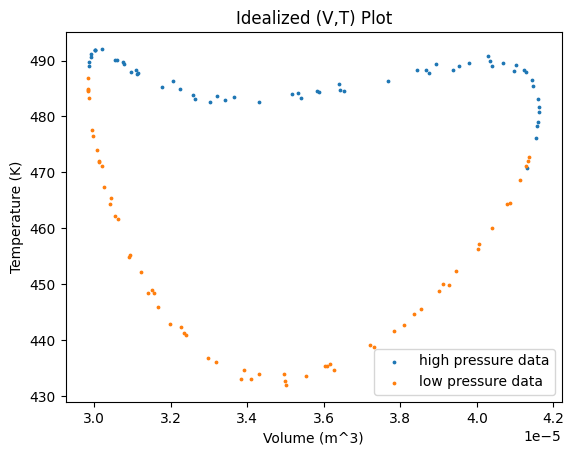

In [8]:
low_press_temp_function = (sorted_lpressure * sorted_lvolume_converted) / (low_n_fit * R)

high_press_temp_function = (sorted_hpressure * sorted_hvolume_converted) / (low_n_fit * R)

plt.scatter(sorted_hvolume_converted, high_press_temp_function, s=3, label="high pressure data")
plt.xlabel('Volume (m^3)')
plt.ylabel('Temperature (K)')

plt.scatter(sorted_lvolume_converted, low_press_temp_function, s=3, label="low pressure data")
plt.xlabel('Volume (m^3)')
plt.ylabel('Temperature (K)')
plt.title("Idealized (V,T) Plot")
plt.legend()
plt.show()

## Efficiency:
The efficiency of the system can be found as:
$$\eta = \frac{\Delta W_{net}}{\Delta Q_{in}}$$
In this equation, we can use the found value for $W_{net}$, while the equation for $\Delta Q_{in}$ can be idealized as:
$$\Delta Q_{in-ideal}=nRT_hln(V_{max}/V_{min})$$
While a non-idealized formulation can be found as:
$$\Delta Q_{in}=nR[T_hln(V_{max}/V_{min})+\frac{5}{2}(1-\eta_{regen})(T_h - T_c)]$$

In [9]:
def q_in(n, temp_hot, temp_cold, v_max, v_min, eta_regen):
    q_in = n * R * ((temp_hot * np.log(v_max/v_min)) + (5/2)*(1-eta_regen)*(temp_hot - temp_cold))
    return q_in

def q_in_ideal(n, temp_hot, v_max, v_min):
    q_in_ideal = n * R * temp_hot * np.log(v_max/v_min)
    return q_in_ideal

In [12]:
t_hot = max(high_press_temp_function)
t_cold = min(low_press_temp_function)
v_max = max(pressure)
v_min = min(pressure)
eta_regen = 0.5
print(f't_h: {t_hot:.2f} K, t_c: {t_cold:.2f} K')
d_work = delta_work(high_n_fit, t_hot, t_cold, v_max, v_min)
print(f'Delta W: {d_work:.2f} J')
energy_in = q_in(high_n_fit, t_hot, t_cold, v_max, v_min, eta_regen)
print(f'Delta Q_in: {energy_in:.2f}')
energy_in_ideal = q_in_ideal(high_n_fit, t_hot, v_max, v_min)
print(f'Delta Q_in (idealized): {energy_in_ideal:.2f}')
print(f'Efficiency (estimating eta_regen as {eta_regen}): {100 * (d_work/energy_in):.2f}%')
print(f'Ideal efficiency (1-T_c/T_h): {(1-(t_cold/t_hot))* 100:.2f}%')

t_h: 492.09 K, t_c: 431.97 K
Delta W: 0.14 J
Delta Q_in: 1.63
Delta Q_in (idealized): 1.15
Efficiency (estimating eta_regen as 0.5): 8.63%
Ideal efficiency (1-T_c/T_h): 12.22%
